<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('data')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_window(path_to_csv_files, site_freq_path, session_length, window_size):
#     train_set = {}
    train_set = pd.DataFrame()
    last_site_id = 1
    fmt = '%Y-%m-%d %H:%M:%S'
    with open(site_freq_path, 'rb') as handle:
        vocabulary = pickle.load(handle)
        
    for file in os.listdir(path_to_csv_files):
        if not file.endswith('.csv'):
            continue
    
#         print(f'File: {file}')
        
        df = pd.read_csv(os.path.join(path_to_csv_files, file))
        
        user_id = int(file[4:-4])
        
        delta = 0 if df.shape[0] % window_size == 0 else 1
        steps_cnt = df.shape[0] // window_size
        steps_cnt += delta
        
        rows_seq = []
        
        for i in range(steps_cnt):
            df_temp = df[i*window_size:(i+1)*window_size].values
            sites_seq = [vocabulary[x[1]][0] for x in df_temp]
            
            unique_sites = np.unique(sites_seq).size
            
            session_timestamp_list = [x[0] for x in df_temp]
            session_timespan_max = datetime.strptime(max(session_timestamp_list), fmt)
            session_timespan_min = datetime.strptime(min(session_timestamp_list), fmt)
            td = session_timespan_max - session_timespan_min
            session_timespan = int(td.total_seconds())
            
            sites_seq = sites_seq + [0] * (session_length - len(sites_seq))
            t = {f'site{key+1}': val for (key, val) in enumerate(sites_seq)}
        
            time_diff = len(session_timestamp_list) % 2
            for j in range(1, len(session_timestamp_list)):
                t_sub = datetime.strptime(session_timestamp_list[j], fmt) - datetime.strptime(session_timestamp_list[j-1], fmt)
                t[f'time_diff{j}'] = int(t_sub.total_seconds())
            while j != session_length - 1:
                j += 1
                t[f'time_diff{j}'] = 0
            t['target'] = user_id
            t['session_timespan'] = session_timespan
            t['#unique_sites'] = unique_sites
            t['start_hour'] = session_timespan_min.hour
            t['day_of_week'] = session_timespan_min.weekday()
            rows_seq.append(t)
            sites_seq = []
                    
        train_set = train_set.append(rows_seq, ignore_index=True)
    return train_set

In [4]:
def make_sparse_data(data):
    indptr = [0]
    indices = []
    sparse_data = []
    for row in data:
        val, cnt = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(val))
        for v, c in zip(val, cnt):
            indices.append(v - 1)
            sparse_data.append(c)
    return np.uint64(sparse_data),  np.uint64(indices), np.uint64(indptr)

In [5]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    train_set = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, session_length, window_size)
    X, y = train_set.iloc[:, :-1].values, train_set.iloc[:, -1].values
    return csr_matrix(make_sparse_data(X)), y

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    train_set = prepare_train_set_window(path_to_csv_files, site_freq_path, session_length, window_size)[feature_names]
    return train_set

**Проверим функцию на игрушечном примере.**

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,3,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
1,4,5,2,5,2,5,5,6,7,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
2,4,5,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
3,1,2,2,8,2,5,9,6,10,11,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
4,1,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 4.63 s, sys: 19 ms, total: 4.65 s
Wall time: 5.07 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,4,4,5,5,6,0.0,1.0,480.0,0.0,1.0,1.0,0.0,2.0,2.0,487,6,8,4,39
1,7,8,7,4,9,10,11,12,9,13,1.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,19.0,30,8,8,4,39
2,14,15,15,9,15,9,9,4,4,9,0.0,1.0,0.0,1.0,21.0,25.0,4.0,1.0,3.0,56,4,8,4,39
3,12,15,15,16,17,13,18,19,20,21,56.0,1.0,31.0,0.0,0.0,3.0,0.0,0.0,0.0,91,9,8,4,39
4,22,23,19,21,24,19,25,26,21,19,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4,7,8,4,39


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 44.9 s, sys: 795 ms, total: 45.7 s
Wall time: 48.6 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features = ['time_diff' + str(j) for j in range(1,10)] + \
               ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [13]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

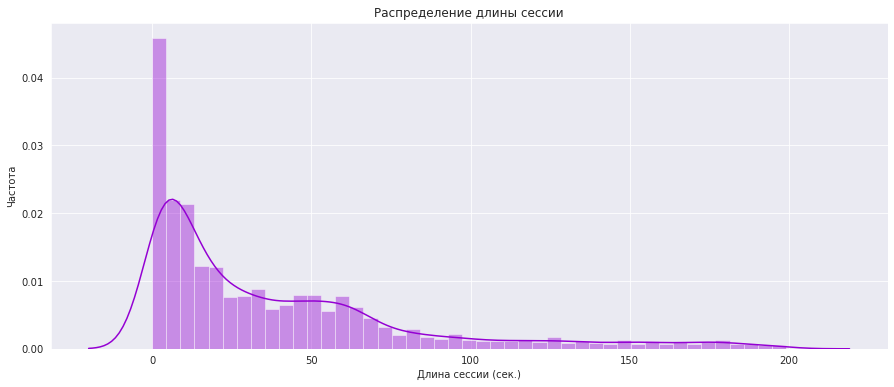

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(train_data_10users[train_data_10users.session_timespan < 200]['session_timespan'], color='darkviolet', ax=ax)

ax.set_xlabel(u'Длина сессии (сек.)')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение длины сессии');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

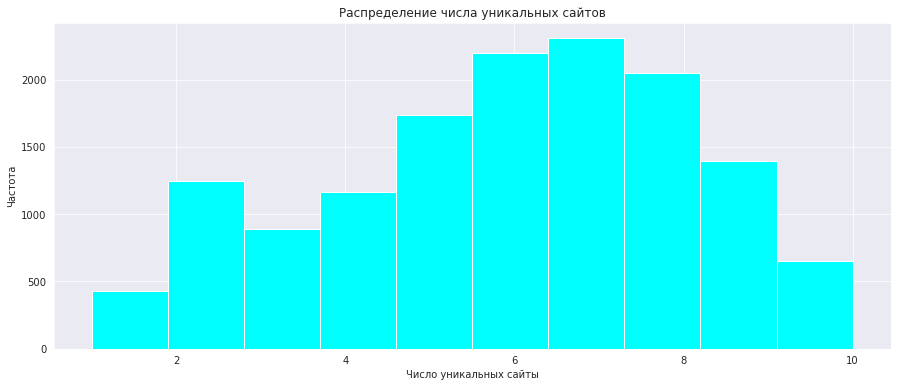

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

train_data_10users['#unique_sites'].plot(kind='hist', ax=ax, color='aqua')

# ax.set_xlim(0, 200)
ax.set_xlabel(u'Число уникальных сайты')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение числа уникальных сайтов');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

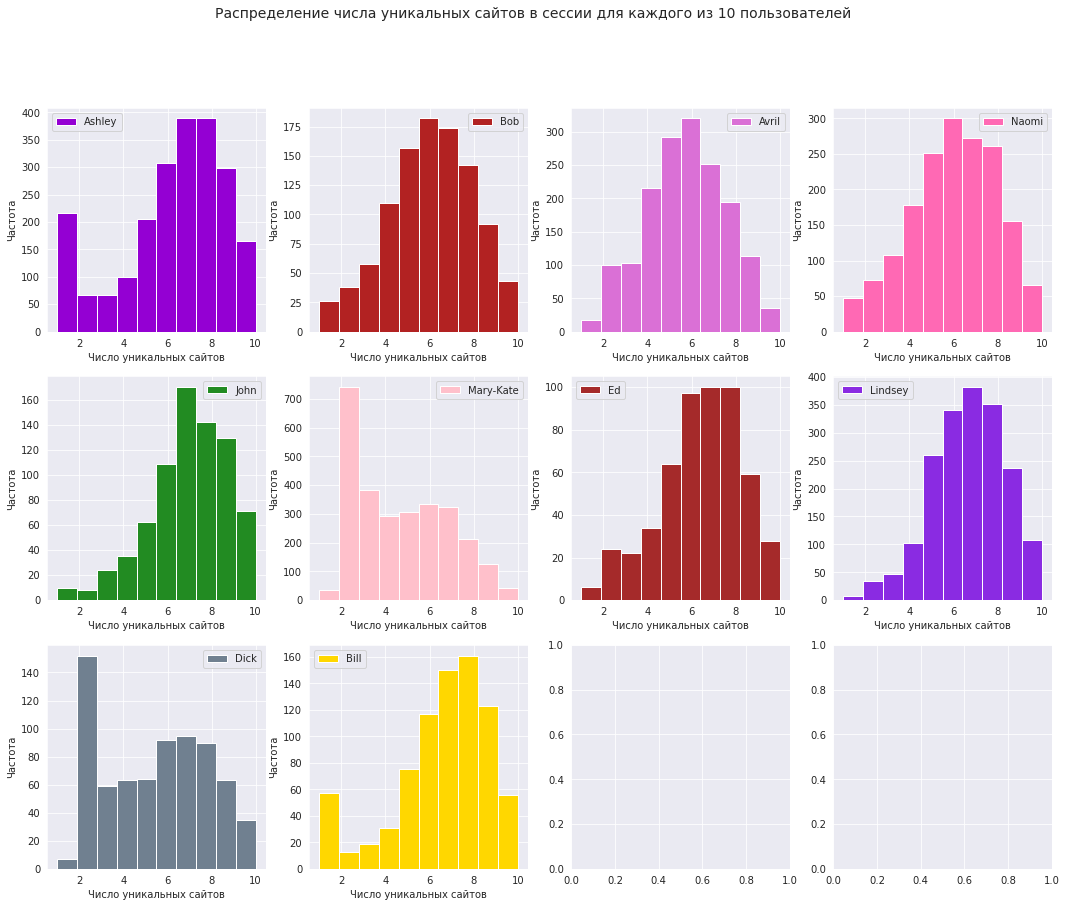

In [41]:
ncols = 4
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 14))

# как вариант, можно и по-другому
usernames = train_data_10users['target'].unique()
n = len(usernames)
for idx, user in enumerate(usernames): 
    ax = axes[idx // ncols][idx % ncols]
    train_data_10users[train_data_10users['target'] == user]['#unique_sites'].plot(kind='hist', color=color_dic[user], ax=ax, bins=10, label=user)
    
    ax.set_xlabel(u'Число уникальных сайтов')
    ax.set_ylabel(u'Частота')
    ax.legend()
plt.suptitle(u'Распределение числа уникальных сайтов в сессии для каждого из 10 пользователей', fontsize=14);

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

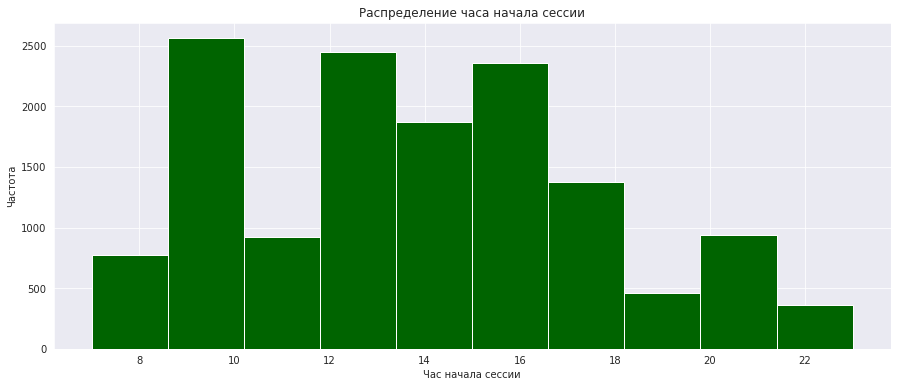

In [44]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

train_data_10users['start_hour'].plot(kind='hist', ax=ax, color='darkgreen')

# ax.set_xlim(0, 200)
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение часа начала сессии');

train_data_10users**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

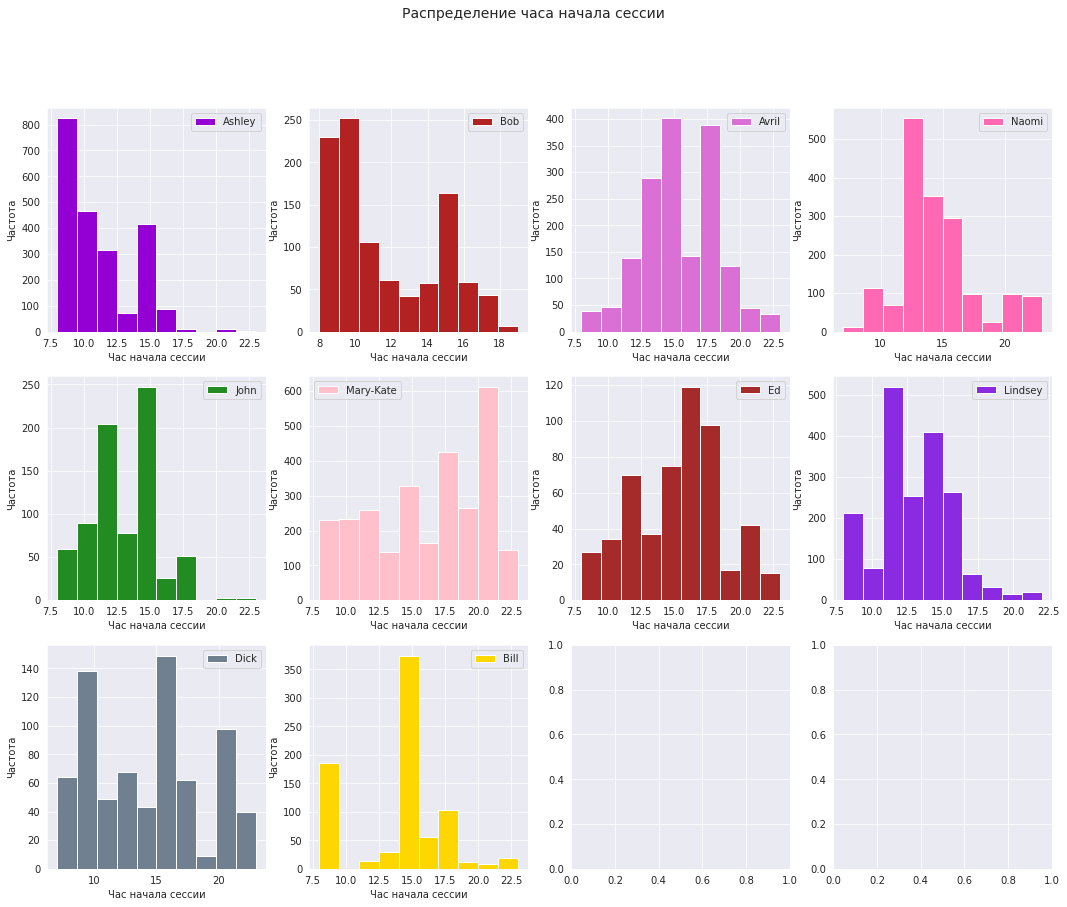

In [45]:
ncols = 4
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 14))

# как вариант, можно и по-другому
usernames = train_data_10users['target'].unique()
n = len(usernames)
for idx, user in enumerate(usernames): 
    ax = axes[idx // ncols][idx % ncols]
    train_data_10users[train_data_10users['target'] == user]['start_hour'].plot(kind='hist', color=color_dic[user], ax=ax, label=user)
    
    ax.set_xlabel(u'Час начала сессии')
    ax.set_ylabel(u'Частота')
    ax.legend()
plt.suptitle(u'Распределение часа начала сессии', fontsize=14);

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

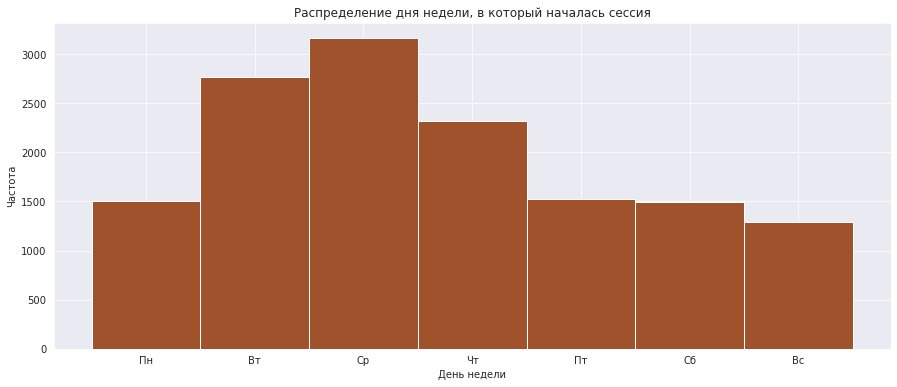

In [54]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

train_data_10users['day_of_week'].plot(kind='hist', ax=ax, color='sienna', bins=np.arange(-0.5,7,1), xticks=range(7))

# ax.set_xlim(0, 200)
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Частота')
ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
ax.set_title(u'Распределение дня недели, в который началась сессия');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

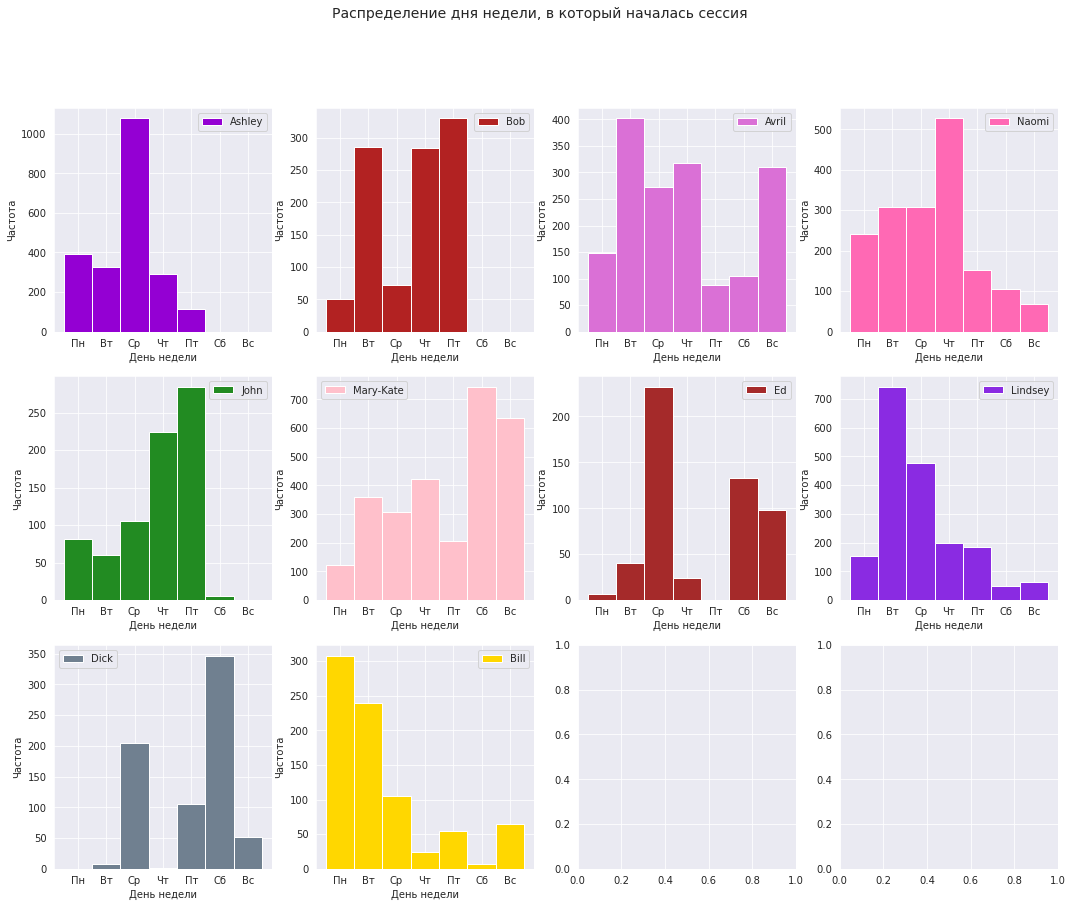

In [55]:
ncols = 4
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 14))

# как вариант, можно и по-другому
usernames = train_data_10users['target'].unique()
n = len(usernames)
for idx, user in enumerate(usernames): 
    ax = axes[idx // ncols][idx % ncols]
    train_data_10users[train_data_10users['target'] == user]['day_of_week'].plot(kind='hist', color=color_dic[user], ax=ax, bins=np.arange(-0.5,7,1), xticks=range(7), label=user)
    
    ax.set_xlabel(u'День недели')
    ax.set_ylabel(u'Частота')
    ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    ax.legend()
plt.suptitle(u'Распределение дня недели, в который началась сессия', fontsize=14);

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [56]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as file:
    vocab10 = pickle.load(file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [57]:
top10_sites = sorted(vocab10, key=lambda x: vocab10[x][1], reverse=True)[:10]
top10_freqs = np.array([vocab10[x][1] for x in top10_sites])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

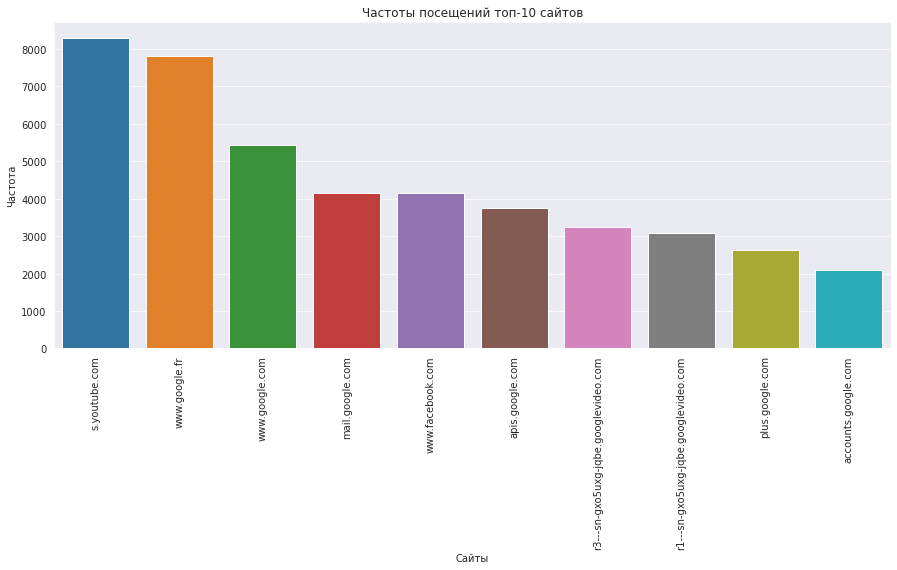

In [58]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x=top10_sites, y=top10_freqs, ax=ax)

# ax.set_xlim(0, 200)
ax.set_xlabel(u'Сайты')
ax.set_ylabel(u'Частота')
ax.set_xticklabels(top10_sites, rotation=90)
ax.set_title(u'Частоты посещений топ-10 сайтов');

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [78]:
'Median session_timespan = %.1f' % train_data_10users.session_timespan.median()

'Median session_timespan = 37.0'

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [79]:
days_list = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

In [80]:
'Median day value = %.0f' % train_data_10users.day_of_week.median()

'Median day value = 2'

In [81]:
'Median day = %s' % days_list[train_data_10users.day_of_week.median().astype(int)]

'Median day = Ср'

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [82]:
'Median start_hour = %.0f' % train_data_150users.start_hour.median()

'Median start_hour = 13'

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [84]:
'Median #unique_sites = %.1f' % train_data_150users['#unique_sites'].median()

'Median #unique_sites = 7.0'

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- будние дни, выходные
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- логарифм длинны сессии
- статистики по time_diff
- кол-во time_diff < 2

In [85]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,2,3,3,4,5,5,6,7,2.0,2.0,289.0,2.0,9.0,3084.0,95.0,1957.0,1.0,5441,7,8,2,569
1,6,8,9,10,9,11,12,13,12,14,6101.0,10.0,0.0,2.0,5.0,1.0,1.0,0.0,1.0,6121,8,9,2,569
2,15,12,14,16,15,12,17,14,18,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,7,11,2,569
3,19,17,17,20,12,21,12,13,22,12,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,5,7,11,2,569
4,23,24,22,16,12,23,23,23,14,23,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4,6,11,2,569


**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 